In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import pickle
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
import random
from scipy.stats import pearsonr
from statistics import mean

from sklearn.cluster import KMeans
from sklearn.neighbors import NearestCentroid
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.metrics import pairwise_distances_argmin_min, pairwise_distances
from sklearn.metrics.pairwise import manhattan_distances

In [3]:
def centroid_dis(row):
  if row['previous_cluster'] == 0 :
      return row[0]
  elif row['previous_cluster'] == 1 :
      return row[1]
  elif row['previous_cluster'] == 2 :
      return row[2]
  elif row['previous_cluster'] == 3 :
      return row[3]
  elif row['previous_cluster'] == 4 :
      return row[4]
  elif row['previous_cluster'] == 5 :
      return row[5]
  elif row['previous_cluster'] == 6 :
      return row[6]
  elif row['previous_cluster'] == 7 :
      return row[7]
  elif row['previous_cluster'] == 8 :
      return row[8] 
  elif row['previous_cluster'] == 9 :
      return row[9]
  elif row['previous_cluster'] == 10 :
      return row[10]
  elif row['previous_cluster'] == 11 :
      return row[11]
  elif row['previous_cluster'] == 12 :
      return row[12]
  elif row['previous_cluster'] == 13 :
      return row[13]
  elif row['previous_cluster'] == 14 :
      return row[14]
  elif row['previous_cluster'] == 15 :
      return row[15]

In [4]:
# Import trained embeddings

with open("/content/drive/My Drive/gmf_item_embedding_neg.pickle", 'rb') as gmf_item:
  trained_gmf_items = pickle.load(gmf_item)
with open("/content/drive/My Drive/mlp_item_embeddings_neg.pickle", 'rb') as mlp_item:
  trained_mlp_items = pickle.load(mlp_item)

# Modify dataset
music_df = pd.read_csv("/content/drive/My Drive/hetrec2011-lastfm-2k/music_tags_new.csv")
df = music_df.pivot_table(index = 'userID',  values = 'artistID', aggfunc=np.count_nonzero).reset_index().rename(columns = {'artistID':'no_of_artists'})
list_id = list(df[df['no_of_artists'] < 10]['userID'])
music_df_new = music_df[~music_df['userID'].isin(list_id)]
item_list = pd.read_csv("/content/drive/My Drive/hetrec2011-lastfm-2k/item_list.csv")

# Merge to get all information
music_df_new = pd.merge(music_df_new, item_list, left_on = 'artistID', right_on = 'artistID')
music_df_new['count'] = 1
music_df_new = music_df_new.sort_values(by=['userID','timestamp'])
music_df_new['artist_order'] = music_df_new.groupby(by=['userID'])['count'].transform(lambda x: x.cumsum())
music_df_new = music_df_new.drop(['count'], axis=1)

# Create new columns
music_df_new['tagValues'] = music_df_new.tagValue.str.split('|')
music_df_new.head()

,userID,artistID,timestamp,tagValue,item_id,artist_order,tagValues
0,2,52,1238536800000,trip-hop,49,1,[trip-hop]
32,2,63,1238536800000,ambient,60,2,[ambient]
71,2,73,1238536800000,chillout,70,3,[chillout]
79,2,94,1238536800000,dance,91,4,[dance]
81,2,96,1238536800000,classic rock,93,5,[classic rock]


In [5]:
# Create latent dataset
item_latent_df_old = pd.DataFrame(trained_mlp_items)
item_latent_df_old['item_id'] = item_latent_df_old.index
item_latent_df_old = pd.merge(item_latent_df_old, item_list, on = 'item_id').dropna()
item_latent_df = pd.merge(item_latent_df_old, music_df_new, on=['item_id', 'artistID'], how='left').dropna()
item_latent_df['Label'] = pd.factorize(item_latent_df['tagValue'])[0] # Create LabelEncoder
label_code_dict = dict(zip(item_latent_df['Label'], item_latent_df['tagValue'])) # Create dict to map LabelEncoder
item_latent_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,item_id,artistID,userID,timestamp,tagValue,artist_order,tagValues,Label
0,0.052539,0.023476,-0.024631,0.067644,0.103806,-0.068023,0.011763,0.107626,-0.103252,0.017602,-0.069121,0.021561,-0.035187,-0.000564,0.005973,0.042243,-0.064984,0.044867,-0.060832,0.120248,0.002603,-0.008793,-0.09473,0.047628,-0.018415,0.078247,-0.033865,-0.041969,-0.024027,-0.11374,-0.014135,0.01517,0,1,37,1214863200000,j-rock,11,[j-rock],0
1,0.052539,0.023476,-0.024631,0.067644,0.103806,-0.068023,0.011763,0.107626,-0.103252,0.017602,-0.069121,0.021561,-0.035187,-0.000564,0.005973,0.042243,-0.064984,0.044867,-0.060832,0.120248,0.002603,-0.008793,-0.09473,0.047628,-0.018415,0.078247,-0.033865,-0.041969,-0.024027,-0.11374,-0.014135,0.01517,0,1,274,1209592800000,j-rock,4,[j-rock],0
2,0.052539,0.023476,-0.024631,0.067644,0.103806,-0.068023,0.011763,0.107626,-0.103252,0.017602,-0.069121,0.021561,-0.035187,-0.000564,0.005973,0.042243,-0.064984,0.044867,-0.060832,0.120248,0.002603,-0.008793,-0.09473,0.047628,-0.018415,0.078247,-0.033865,-0.041969,-0.024027,-0.11374,-0.014135,0.01517,0,1,681,1217541600000,j-rock,21,[j-rock],0
3,0.052539,0.023476,-0.024631,0.067644,0.103806,-0.068023,0.011763,0.107626,-0.103252,0.017602,-0.069121,0.021561,-0.035187,-0.000564,0.005973,0.042243,-0.064984,0.044867,-0.060832,0.120248,0.002603,-0.008793,-0.09473,0.047628,-0.018415,0.078247,-0.033865,-0.041969,-0.024027,-0.11374,-0.014135,0.01517,0,1,785,1280613600000,j-rock,15,[j-rock],0
4,0.052539,0.023476,-0.024631,0.067644,0.103806,-0.068023,0.011763,0.107626,-0.103252,0.017602,-0.069121,0.021561,-0.035187,-0.000564,0.005973,0.042243,-0.064984,0.044867,-0.060832,0.120248,0.002603,-0.008793,-0.09473,0.047628,-0.018415,0.078247,-0.033865,-0.041969,-0.024027,-0.11374,-0.014135,0.01517,0,1,1545,1199142000000,j-rock,10,[j-rock],0


In [6]:
# K-Means
# Define target variables
X = item_latent_df_old.iloc[:, np.r_[0:32]].to_numpy()
Y = item_latent_df_old['item_id']
print(X,Y)

[[ 0.05253935  0.02347595 -0.02463094 ... -0.11373956 -0.01413546
   0.01516957]
 [ 0.33926314  0.3464865  -0.09424973 ...  0.00916537  0.11096475
   0.14590468]
 [-0.05540543  0.19059993  0.14613028 ...  0.1514646  -0.10264678
  -0.25337225]
 ...
 [ 0.02704465  0.0907893   0.29506555 ... -0.06535555  0.05968812
  -0.15844452]
 [-0.09925187  0.2009251   0.0901074  ...  0.25067973 -0.18644658
  -0.06266091]
 [ 0.0368033   0.23122936  0.03232606 ...  0.13007921 -0.1366629
  -0.08902196]] 0            0
1            1
2            2
3            3
4            4
         ...  
10715    10715
10716    10716
10717    10717
10718    10718
10719    10719
Name: item_id, Length: 10720, dtype: int64


For n_clusters = 3 The average silhouette_score is : 0.08040721
For n_clusters = 5 The average silhouette_score is : 0.07438825
For n_clusters = 10 The average silhouette_score is : 0.0662084


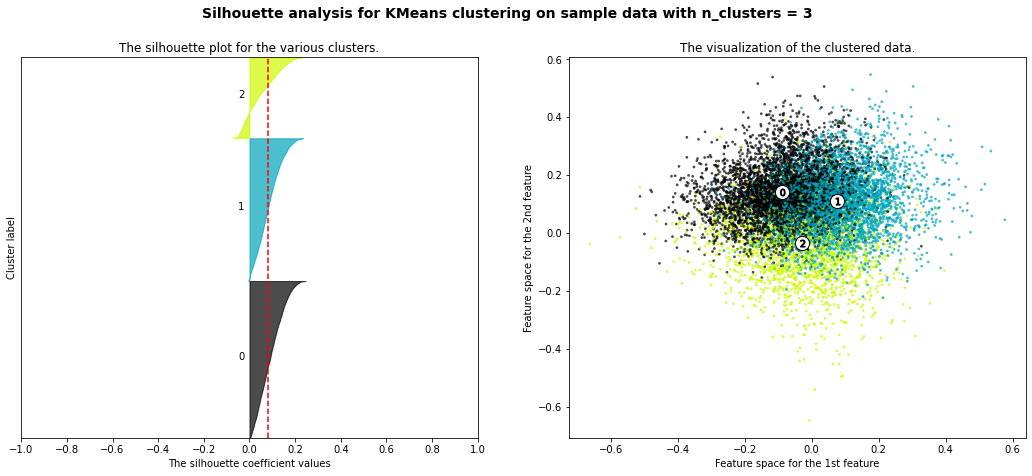

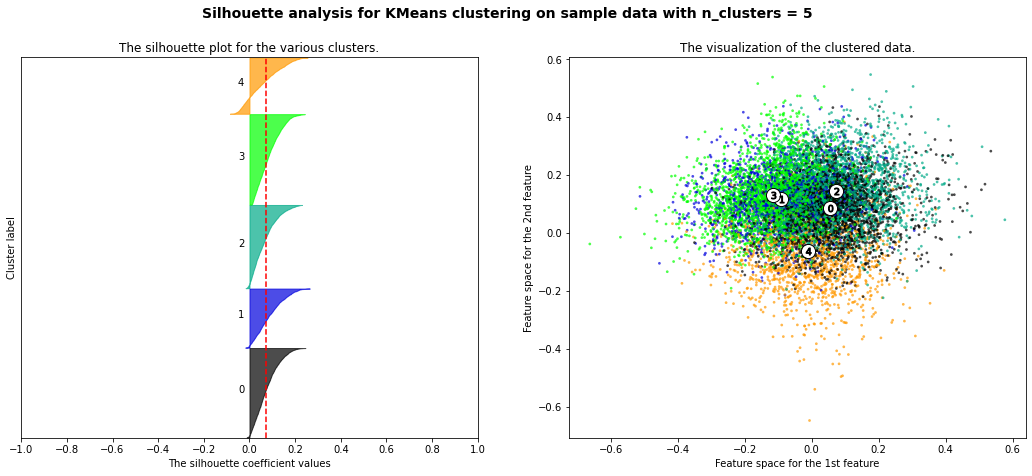

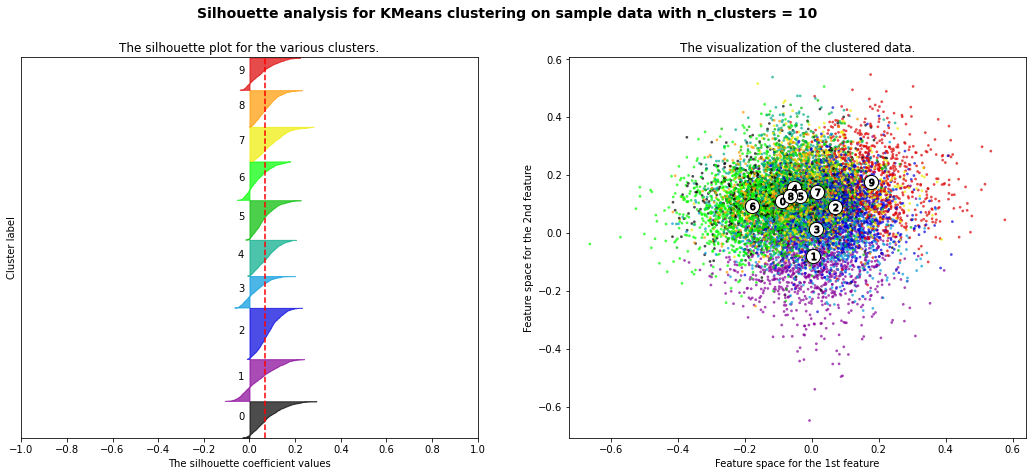

In [ ]:
# Silhouette analysis

range_n_clusters = [3,5,10]

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The silhouette coefficient can range from -1, 1 
    ax1.set_xlim([-1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters = n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-1, -0.8, -0.6, -0.4, -0.2, 0.0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(X[:, 0], X[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

plt.show()

In [8]:
# Define cluster from Silhouette analysis
n_clusters = 3

clusterer = KMeans(n_clusters = n_clusters, random_state=10)
cluster_labels = clusterer.fit_predict(X)
closest, min_dist = pairwise_distances_argmin_min(X, clusterer.cluster_centers_)

# Create distance to centroid
distance_nearest_centroid = pd.DataFrame(min_dist)
distance_nearest_centroid_df = distance_nearest_centroid.rename(columns = {0: 'distance_centroid'})
distance_nearest_centroid_df['item_id'] = distance_nearest_centroid_df.index

# Create dataset contains new label
dataset_cluster_label = pd.DataFrame(cluster_labels, columns=['cluster_label'])
dataset_cluster_label['item_id'] = dataset_cluster_label.index
dataset_cluster_label = pd.merge(dataset_cluster_label, item_latent_df, on = 'item_id').dropna()
dataset_cluster_label = dataset_cluster_label.drop(columns=['userID', 'timestamp', 'artist_order', 'Label'])
dataset_cluster_label = pd.merge(dataset_cluster_label, distance_nearest_centroid_df, on = 'item_id').dropna()
dataset_cluster_label = dataset_cluster_label.drop(columns=['tagValues']).drop_duplicates()
dataset_cluster_label['tagValues'] = dataset_cluster_label.tagValue.str.split('|')

# Distance of each point to the 15 clusters
X_np = np.array(X)
centroids = clusterer.cluster_centers_
distance = []
for i in X_np:
    data_point = np.array(i).reshape(1,-1)
    distance_to_point = pairwise_distances(data_point, centroids)
    distance.extend(distance_to_point)
distance_all_centroids_df = pd.DataFrame(distance)
distance_all_centroids_df['item_id'] = distance_all_centroids_df.index

# Create centroid df
centroids_df = dataset_cluster_label[['item_id', 'artistID', 'tagValue', 'cluster_label', 'distance_centroid']]
centroids_df = pd.merge(centroids_df, distance_all_centroids_df, on = 'item_id').dropna()
centroids_df = centroids_df.drop_duplicates()

Number of artists with trip-hop tag value : 59
all users:  374  validation check on no duplicates:  374
final df with number of datapoints:  2


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:129: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misint

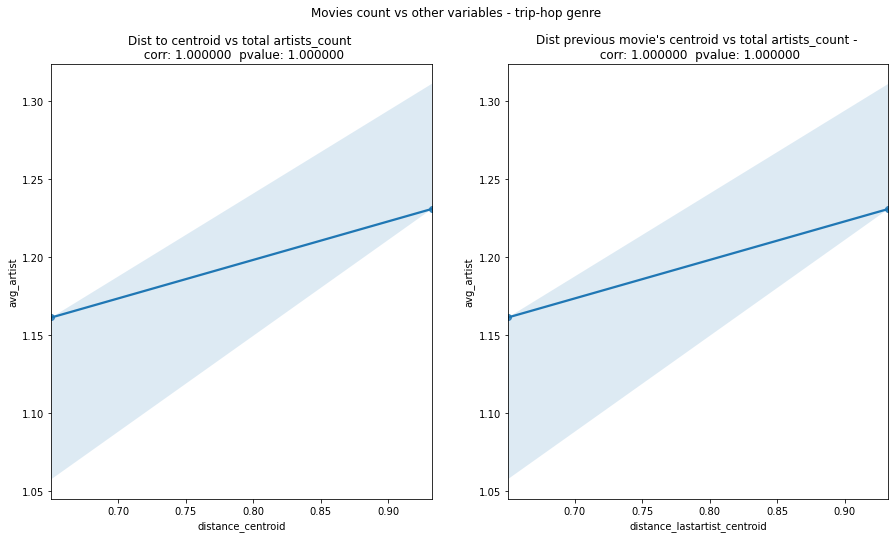

Number of artists with ambient tag value : 177
all users:  503  validation check on no duplicates:  503
final df with number of datapoints:  1
ambient has less than 2 datapoints 

Number of artists with chillout tag value : 101


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:129: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


all users:  223  validation check on no duplicates:  223
final df with number of datapoints:  0
chillout has less than 2 datapoints 

Number of artists with dance tag value : 155
all users:  487  validation check on no duplicates:  487
final df with number of datapoints:  0
dance has less than 2 datapoints 

Number of artists with classic rock tag value : 130
all users:  834  validation check on no duplicates:  834
final df with number of datapoints:  6


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:129: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misint

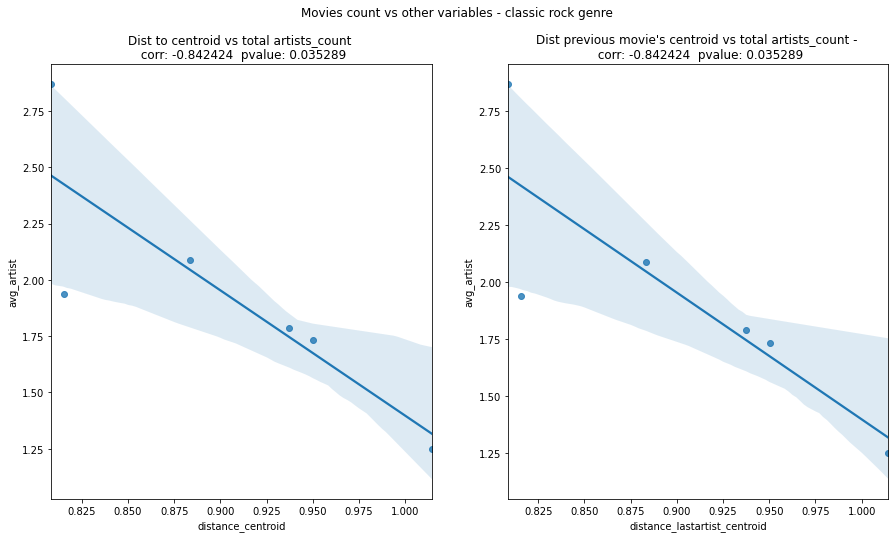

Number of artists with 80s tag value : 200
all users:  747  validation check on no duplicates:  747


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:129: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misint

final df with number of datapoints:  2


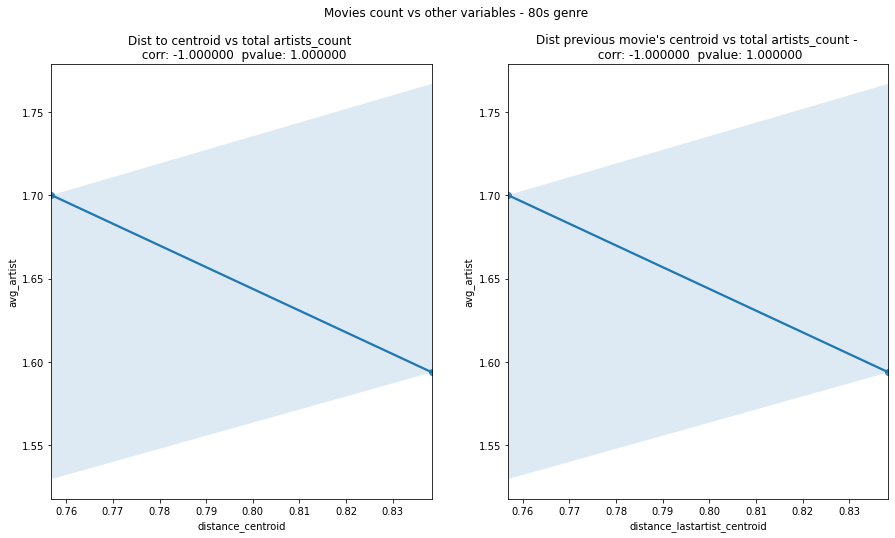

Number of artists with emocore tag value : 11
all users:  35  validation check on no duplicates:  35
final df with number of datapoints:  0
emocore has less than 2 datapoints 

Number of artists with progressive rock tag value : 121
all users:  449  validation check on no duplicates:  449
final df with number of datapoints:  0
progressive rock has less than 2 datapoints 

Number of artists with epic tag value : 41
all users:  168  validation check on no duplicates:  168
final df with number of datapoints:  0
epic has less than 2 datapoints 

Number of artists with indie tag value : 400
all users:  1055  validation check on no duplicates:  1055
final df with number of datapoints:  0
indie has less than 2 datapoints 

Number of artists with progressive metal tag value : 70
all users:  221  validation check on no duplicates:  221
final df with number of datapoints:  0
progressive metal has less than 2 datapoints 

Number of artists with metal tag value : 87
all users:  446  validation che

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:129: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misint

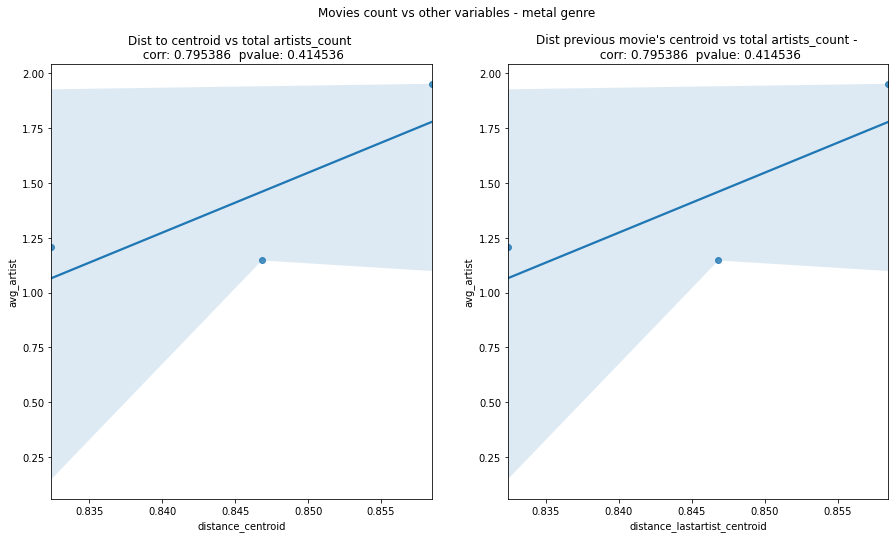

Number of artists with rock tag value : 654
all users:  1484  validation check on no duplicates:  1484


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:129: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


final df with number of datapoints:  1
rock has less than 2 datapoints 

Number of artists with indie rock tag value : 102
all users:  484  validation check on no duplicates:  484
final df with number of datapoints:  2


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:129: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misint

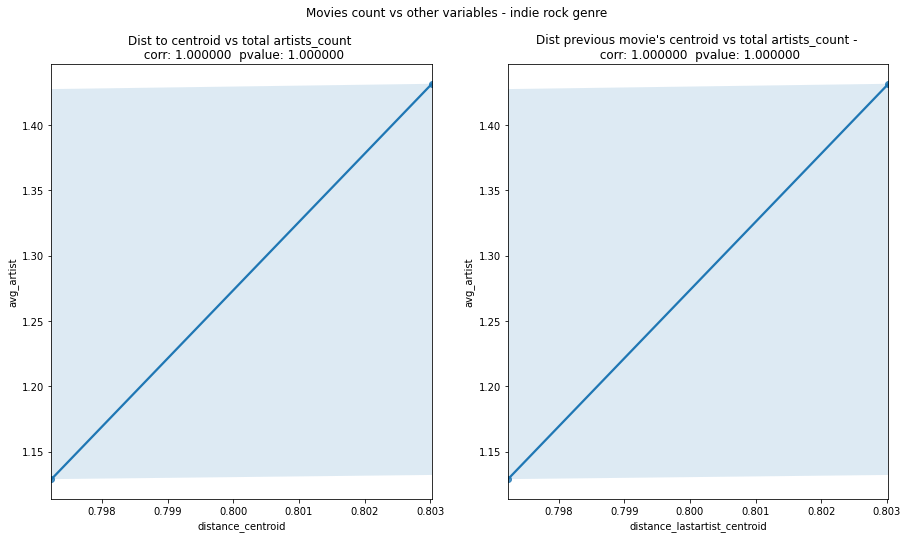

Number of artists with funk tag value : 37
all users:  158  validation check on no duplicates:  158
final df with number of datapoints:  0
funk has less than 2 datapoints 

Number of artists with electronic tag value : 550
all users:  1218  validation check on no duplicates:  1218


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:129: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


final df with number of datapoints:  1
electronic has less than 2 datapoints 

Number of artists with thrash metal tag value : 61
all users:  218  validation check on no duplicates:  218
final df with number of datapoints:  0
thrash metal has less than 2 datapoints 

Number of artists with christian tag value : 34
all users:  106  validation check on no duplicates:  106
final df with number of datapoints:  0
christian has less than 2 datapoints 

Number of artists with alternative tag value : 298
all users:  1148  validation check on no duplicates:  1148


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:129: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misint

final df with number of datapoints:  2


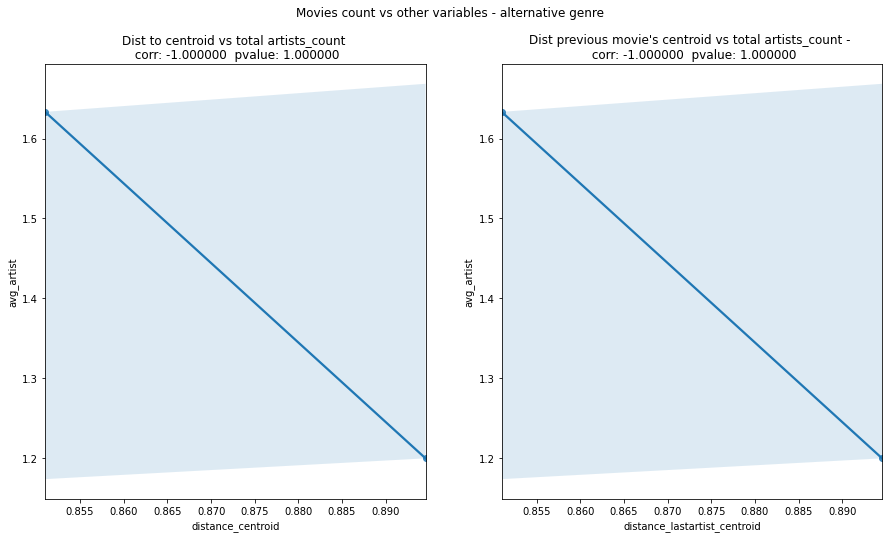

Number of artists with other tag value : 269
all users:  524  validation check on no duplicates:  524
final df with number of datapoints:  1
other has less than 2 datapoints 



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:129: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Number of artists with post-rock tag value : 80
all users:  207  validation check on no duplicates:  207
final df with number of datapoints:  0
post-rock has less than 2 datapoints 

Number of artists with melodic death metal tag value : 51
all users:  191  validation check on no duplicates:  191
final df with number of datapoints:  0
melodic death metal has less than 2 datapoints 

Number of artists with pop tag value : 486
all users:  1015  validation check on no duplicates:  1015
final df with number of datapoints:  0
pop has less than 2 datapoints 

Number of artists with hard rock tag value : 113
all users:  500  validation check on no duplicates:  500
final df with number of datapoints:  1
hard rock has less than 2 datapoints 

Number of artists with idm tag value : 85


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:129: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


all users:  146  validation check on no duplicates:  146
final df with number of datapoints:  0
idm has less than 2 datapoints 

Number of artists with trance tag value : 33
all users:  75  validation check on no duplicates:  75
final df with number of datapoints:  0
trance has less than 2 datapoints 

Number of artists with jazz tag value : 139
all users:  468  validation check on no duplicates:  468
final df with number of datapoints:  0
jazz has less than 2 datapoints 

Number of artists with synthpop tag value : 51
all users:  148  validation check on no duplicates:  148
final df with number of datapoints:  0
synthpop has less than 2 datapoints 

Number of artists with ebm tag value : 67
all users:  132  validation check on no duplicates:  132
final df with number of datapoints:  0
ebm has less than 2 datapoints 

Number of artists with alternative rock tag value : 95
all users:  517  validation check on no duplicates:  517
final df with number of datapoints:  2


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:129: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misint

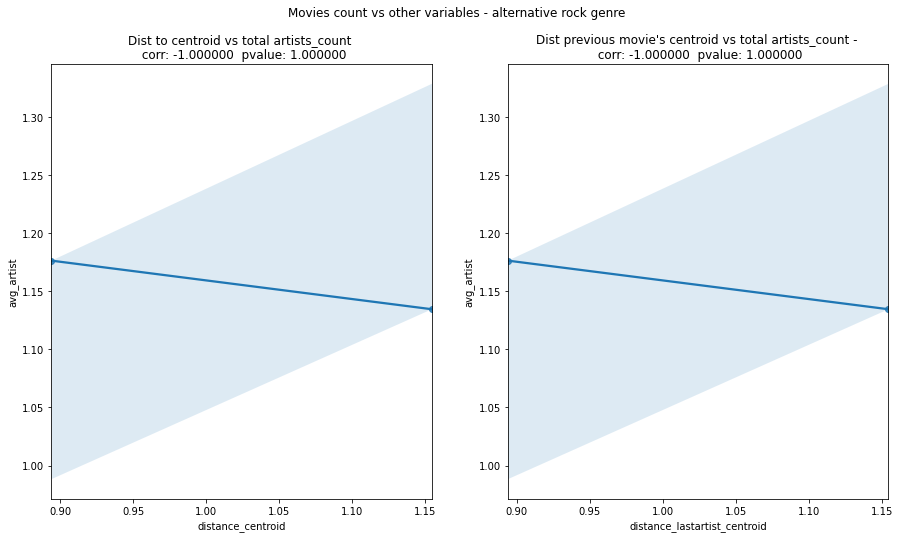

Number of artists with singer-songwriter tag value : 109
all users:  402  validation check on no duplicates:  402
final df with number of datapoints:  0
singer-songwriter has less than 2 datapoints 

Number of artists with seen live tag value : 98
all users:  156  validation check on no duplicates:  156
final df with number of datapoints:  0
seen live has less than 2 datapoints 

Number of artists with industrial tag value : 103
all users:  301  validation check on no duplicates:  301
final df with number of datapoints:  0
industrial has less than 2 datapoints 

Number of artists with psychedelic tag value : 29
all users:  156  validation check on no duplicates:  156
final df with number of datapoints:  1
psychedelic has less than 2 datapoints 

Number of artists with classical tag value : 70


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:129: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


all users:  200  validation check on no duplicates:  200
final df with number of datapoints:  0
classical has less than 2 datapoints 

Number of artists with experimental tag value : 202
all users:  441  validation check on no duplicates:  441
final df with number of datapoints:  0
experimental has less than 2 datapoints 

Number of artists with hip-hop tag value : 253
all users:  569  validation check on no duplicates:  569
final df with number of datapoints:  1
hip-hop has less than 2 datapoints 

Number of artists with blues tag value : 58


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:129: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


all users:  172  validation check on no duplicates:  172
final df with number of datapoints:  0
blues has less than 2 datapoints 

Number of artists with doom metal tag value : 18
all users:  81  validation check on no duplicates:  81
final df with number of datapoints:  0
doom metal has less than 2 datapoints 

Number of artists with j-rock tag value : 65
all users:  129  validation check on no duplicates:  129
final df with number of datapoints:  0
j-rock has less than 2 datapoints 

Number of artists with j-pop tag value : 27
all users:  53  validation check on no duplicates:  53
final df with number of datapoints:  0
j-pop has less than 2 datapoints 

Number of artists with japanese tag value : 58
all users:  91  validation check on no duplicates:  91
final df with number of datapoints:  0
japanese has less than 2 datapoints 

Number of artists with california tag value : 33
all users:  39  validation check on no duplicates:  39
final df with number of datapoints:  0
california has

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:129: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misint

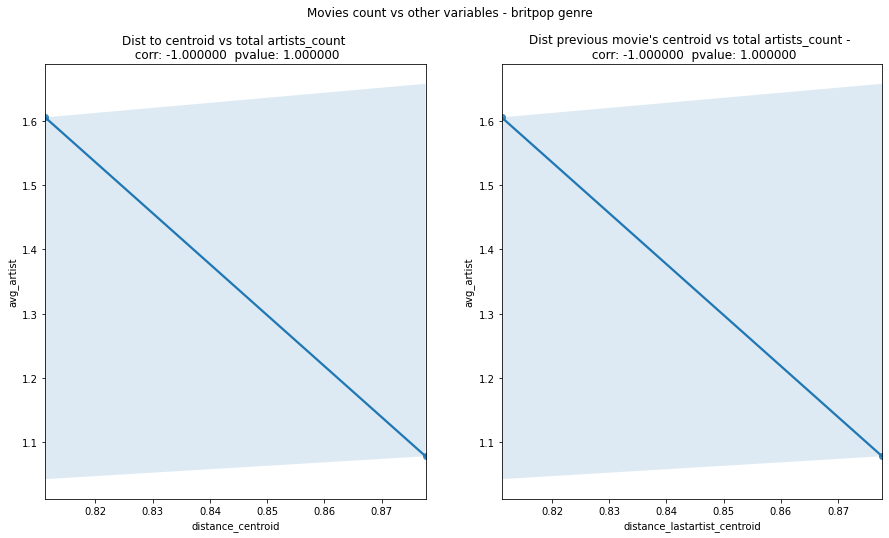

Number of artists with korean tag value : 22
all users:  33  validation check on no duplicates:  33
final df with number of datapoints:  0
korean has less than 2 datapoints 

Number of artists with jrock tag value : 8
all users:  7  validation check on no duplicates:  7
final df with number of datapoints:  0
jrock has less than 2 datapoints 

Number of artists with punk rock tag value : 41
all users:  255  validation check on no duplicates:  255
final df with number of datapoints:  1
punk rock has less than 2 datapoints 

Number of artists with french tag value : 53


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:129: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


all users:  132  validation check on no duplicates:  132
final df with number of datapoints:  0
french has less than 2 datapoints 

Number of artists with punk tag value : 171
all users:  541  validation check on no duplicates:  541
final df with number of datapoints:  2


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:129: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misint

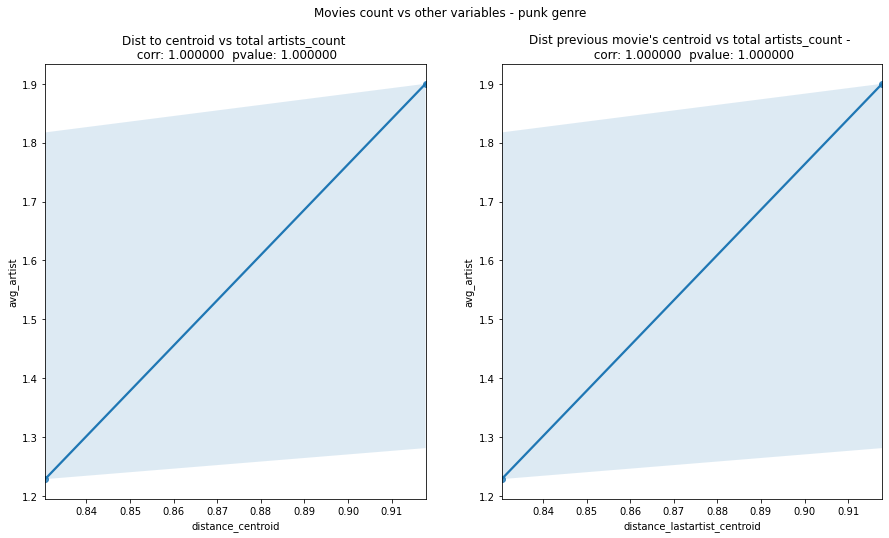

Number of artists with country tag value : 88
all users:  258  validation check on no duplicates:  258
final df with number of datapoints:  1
country has less than 2 datapoints 

Number of artists with pop rock tag value : 18


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:129: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


all users:  64  validation check on no duplicates:  64
final df with number of datapoints:  0
pop rock has less than 2 datapoints 

Number of artists with folk tag value : 147
all users:  496  validation check on no duplicates:  496
final df with number of datapoints:  1
folk has less than 2 datapoints 

Number of artists with rap tag value : 55


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:129: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


all users:  207  validation check on no duplicates:  207
final df with number of datapoints:  1
rap has less than 2 datapoints 

Number of artists with rnb tag value : 93


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:129: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


all users:  379  validation check on no duplicates:  379
final df with number of datapoints:  1
rnb has less than 2 datapoints 

Number of artists with grunge tag value : 16


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:129: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


all users:  232  validation check on no duplicates:  232
final df with number of datapoints:  1
grunge has less than 2 datapoints 

Number of artists with pop punk tag value : 36


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:129: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


all users:  186  validation check on no duplicates:  186
final df with number of datapoints:  0
pop punk has less than 2 datapoints 

Number of artists with gothic tag value : 38
all users:  131  validation check on no duplicates:  131
final df with number of datapoints:  0
gothic has less than 2 datapoints 

Number of artists with emo tag value : 41
all users:  94  validation check on no duplicates:  94
final df with number of datapoints:  0
emo has less than 2 datapoints 

Number of artists with metalcore tag value : 119
all users:  259  validation check on no duplicates:  259
final df with number of datapoints:  0
metalcore has less than 2 datapoints 

Number of artists with post-hardcore tag value : 70
all users:  207  validation check on no duplicates:  207
final df with number of datapoints:  0
post-hardcore has less than 2 datapoints 

Number of artists with darkwave tag value : 22
all users:  87  validation check on no duplicates:  87
final df with number of datapoints:  0
dark

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:129: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misint

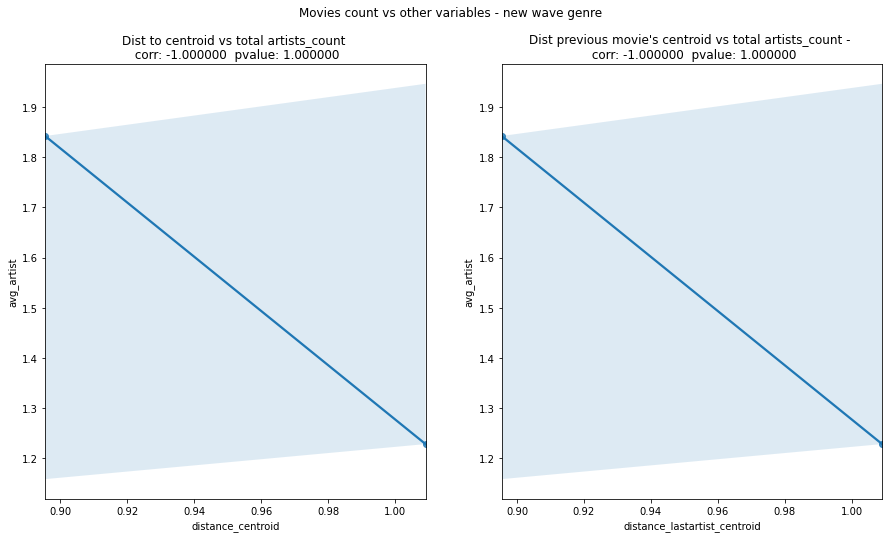

Number of artists with instrumental tag value : 99
all users:  311  validation check on no duplicates:  311
final df with number of datapoints:  0
instrumental has less than 2 datapoints 

Number of artists with italian tag value : 18
all users:  60  validation check on no duplicates:  60
final df with number of datapoints:  0
italian has less than 2 datapoints 

Number of artists with post-punk tag value : 58
all users:  301  validation check on no duplicates:  301
final df with number of datapoints:  1
post-punk has less than 2 datapoints 

Number of artists with worldmusic tag value : 20


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:129: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


all users:  36  validation check on no duplicates:  36
final df with number of datapoints:  0
worldmusic has less than 2 datapoints 

Number of artists with ska tag value : 34
all users:  89  validation check on no duplicates:  89
final df with number of datapoints:  0
ska has less than 2 datapoints 

Number of artists with 60s tag value : 50
all users:  235  validation check on no duplicates:  235
final df with number of datapoints:  0
60s has less than 2 datapoints 

Number of artists with power pop tag value : 8
all users:  33  validation check on no duplicates:  33
final df with number of datapoints:  0
power pop has less than 2 datapoints 

Number of artists with witty tag value : 40
all users:  42  validation check on no duplicates:  42
final df with number of datapoints:  0
witty has less than 2 datapoints 

Number of artists with 50s tag value : 7
all users:  27  validation check on no duplicates:  27
final df with number of datapoints:  0
50s has less than 2 datapoints 

Numbe

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:129: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misint

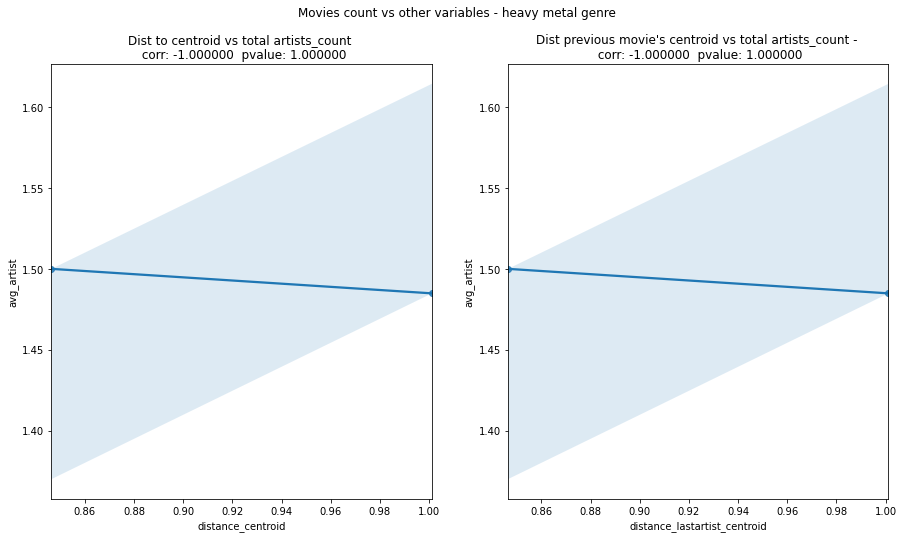

Number of artists with rockabilly tag value : 12
all users:  32  validation check on no duplicates:  32
final df with number of datapoints:  0
rockabilly has less than 2 datapoints 

Number of artists with nostalgia tag value : 22
all users:  49  validation check on no duplicates:  49
final df with number of datapoints:  0
nostalgia has less than 2 datapoints 

Number of artists with hand claps tag value : 13
all users:  23  validation check on no duplicates:  23
final df with number of datapoints:  0
hand claps has less than 2 datapoints 

Number of artists with full-on tag value : 21
all users:  36  validation check on no duplicates:  36
final df with number of datapoints:  0
full-on has less than 2 datapoints 

Number of artists with noise tag value : 27
all users:  75  validation check on no duplicates:  75
final df with number of datapoints:  0
noise has less than 2 datapoints 

Number of artists with masterpiece tag value : 19
all users:  20  validation check on no duplicates:  2

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:129: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


all users:  119  validation check on no duplicates:  119
final df with number of datapoints:  0
shoegaze has less than 2 datapoints 

Number of artists with british tag value : 58
all users:  241  validation check on no duplicates:  241
final df with number of datapoints:  1
british has less than 2 datapoints 

Number of artists with makes me smile tag value : 33


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:129: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


all users:  36  validation check on no duplicates:  36
final df with number of datapoints:  0
makes me smile has less than 2 datapoints 

Number of artists with vocal tag value : 13
all users:  25  validation check on no duplicates:  25
final df with number of datapoints:  0
vocal has less than 2 datapoints 

Number of artists with synth pop tag value : 4
all users:  10  validation check on no duplicates:  10
final df with number of datapoints:  0
synth pop has less than 2 datapoints 

Number of artists with avant-garde tag value : 12
all users:  32  validation check on no duplicates:  32
final df with number of datapoints:  0
avant-garde has less than 2 datapoints 

Number of artists with male tag value : 7
all users:  23  validation check on no duplicates:  23
final df with number of datapoints:  0
male has less than 2 datapoints 

Number of artists with 2009 tag value : 48
all users:  68  validation check on no duplicates:  68
final df with number of datapoints:  0
2009 has less tha

In [ ]:
# Define number of movies before and after stepping stones
n_front = 10
n_back = 10

# Find unique tagvalus
all_tagValue = music_df_new[['artistID', 'tagValue']]
all_tagValue = all_tagValue.drop_duplicates()
unique_tagValue = list(all_tagValue['tagValue'].str.split('|', expand=True).stack().unique())

# Create results dataset
all_genres_df = pd.DataFrame()

#for type_tagValue in unique_tagValue:
for type_tagValue in unique_tagValue:

  all_users_target = pd.DataFrame()

  # Fliter target tag value
  sub_df = all_tagValue[all_tagValue['tagValue'] == type_tagValue]
  selected_artist = list(set(sub_df['artistID']))
  print('Number of artists with', type_tagValue, 'tag value :',len(selected_artist))

  for target in selected_artist:
    # chosee only instances where the selected artist has at least 'n_front' artists before them (improve computational effiency)
    # Only user who give selected_artist target tagValue #
    filter_artist = music_df_new[(music_df_new['artistID'] == target) & (music_df_new.tagValue.str.contains(type_tagValue)) &(music_df_new['artist_order'] > n_front)] # Selected artists 

    # to ignore blank dataframes
    if len(filter_artist) != 0:
      # Check when user watch selected movies
      order_dict = {}
      for i in list(filter_artist.index.values):
        order_dict[filter_artist['userID'][i]] = filter_artist['artist_order'][i]
      
      # Create user path dataframe
      seq_df = pd.DataFrame()
      for k in list(order_dict.keys()):
        df_temp = music_df_new.loc[(music_df_new['userID'] == k) & ((order_dict[k] - n_front) <= music_df_new['artist_order']) & ((order_dict[k] + n_back) >= music_df_new['artist_order'])]
        seq_df = pd.concat([seq_df, df_temp])

      seq_df['count'] = 1
      seq_df['new_artist_order'] = seq_df.groupby(by = ['userID'])['count'].transform(lambda x: x.cumsum())
      genres_seq_first = seq_df.groupby('userID')['tagValues'].apply(lambda x: x.tolist()) # Get sequence of tagValues by user

      user_path_df = pd.DataFrame()
      for user in list(genres_seq_first.index.values):
        check_previous = 0
        for j in genres_seq_first[user][:n_front]: # check previous artists not in selected tagValue
          if type_tagValue not in j:
            check_previous += 1
        if check_previous == n_front: # and num_artists >= n_after: 
          user_path_df = pd.concat([user_path_df, seq_df[seq_df['userID'] == user][['userID','artistID','tagValue','timestamp', 'new_artist_order']]])

      # Next steps - using the user_path_df of the target movie, find all users' previous movie cluster and target movie cluster and distance

      if len(user_path_df) != 0: 
        all_user_path_df = pd.merge(user_path_df, dataset_cluster_label, how = 'left', on = ['artistID','tagValue'])

        na_users = all_user_path_df[all_user_path_df.isnull().any(axis=1)].userID
        all_users = all_user_path_df.userID.unique()
        filtered_users = set(all_users) - set(na_users)

        stepping_stone = []
        target_tagvalue_list = []
        previous_cluster_label_list = []
        target_cluster_label_list = []
        linear_distance_list = []
        nonlinear_distance_list = []
        num_artists = []
        users_list = []

        for user_target in filtered_users:
          df = all_user_path_df[all_user_path_df['userID'] == user_target]
          artistID = df.iloc[n_front: n_front +1,]['artistID'].values.tolist()
          target_tagvalue = df.iloc[n_front: n_front +1,]['tagValue'].values.tolist()
          previous_label = df.iloc[n_front -1:n_front,]['cluster_label'].values.tolist()
          target_label = df.iloc[n_front:n_front+1,]['cluster_label'].values.tolist()

          users_list.append(user_target)
          stepping_stone.extend(artistID)
          target_tagvalue_list.extend(target_tagvalue)
          previous_cluster_label_list.extend(previous_label)
          target_cluster_label_list.extend(target_label)

          # find distance
          target_location = df[df['userID']== user_target][n_front: n_front + 1][np.r_[0:32]].to_numpy() 
          previous_location = df[df['userID'] == user_target][n_front-1 : n_front][np.r_[0:32]].to_numpy()
          linear_distance_list.append(np.linalg.norm(target_location - previous_location))
          nonlinear_distance_list.extend(manhattan_distances(target_location, previous_location).ravel())

          tagValue_seq = df.groupby('userID')['tagValues'].apply(lambda x: x.tolist()) # Get sequence of tagValues  by user

          count = 0
          for tagValue_list in tagValue_seq[user_target][n_front:]: 
            if type_tagValue in tagValue_list:
              count += 1
          num_artists.append(count)

        final_df = pd.DataFrame({'user': users_list, 'target_tagvalue': target_tagvalue_list,'target_cluster': target_cluster_label_list, 'previous_cluster':previous_cluster_label_list,
                                 'target_artist':stepping_stone, 'linear_distance': linear_distance_list, 'nonlinear_distance': nonlinear_distance_list, 'artists_count': num_artists})
    
        all_users_target = pd.concat([all_users_target, final_df])

  # Check duplicate
  new_df = all_users_target.drop_duplicates()
  print('all users: ', len(all_users_target), ' validation check on no duplicates: ', len(new_df))
  if len(all_users_target) != 0:

    # use the above condition to filter out the corresponding movie_cluster
    new_df2 = pd.merge(new_df, centroids_df, how = 'left', left_on = ['target_artist', 'target_tagvalue'] , right_on = ['artistID','tagValue'])
    new_df2['distance_lastartist_centroid'] = new_df2.apply (lambda row: centroid_dis(row), axis=1)
    new_df2['user_count'] = 1
    analysis = new_df2[['user', 'target_cluster', 'previous_cluster', 'target_artist', 'linear_distance', 'nonlinear_distance', 'artists_count', 'user_count',
                                'distance_centroid', 'distance_lastartist_centroid']]
    users_in_tagValue  = analysis.pivot_table(values = ['artists_count','user_count'], index = ['target_artist', 'target_cluster', 'previous_cluster'],
                                                  aggfunc = {'artists_count': np.sum, 'user_count' : np.sum}).reset_index()
            
    centroids_dis = analysis[['target_cluster', 'previous_cluster', 'target_artist', 'distance_centroid', 'distance_lastartist_centroid']]
    centroids_dis = centroids_dis.drop_duplicates()

    testing = analysis[['target_cluster', 'previous_cluster', 'target_artist', 'linear_distance', 'artists_count', 'nonlinear_distance']]
    testing_corr = testing.groupby(['target_cluster', 'previous_cluster', 'target_artist']).corr().reset_index()
    testing_corr = testing_corr[testing_corr['level_3'] == 'artists_count'].drop(['artists_count'], axis = 1)

    final_analysis1 = pd.merge(testing_corr, users_in_tagValue, how = 'left', on = ['target_artist', 'target_cluster', 'previous_cluster'])
    final_analysis2 = pd.merge(final_analysis1, centroids_dis, how = 'left', on = ['target_artist', 'target_cluster', 'previous_cluster'])
    filter_users = final_analysis2[final_analysis2['user_count'] >= 30] # pvalue
    #filter_users = final_analysis2
    filter_users['avg_artist'] = filter_users['artists_count'] / filter_users['user_count']
    filter_users['genre'] = type_tagValue 
    print('final df with number of datapoints: ', len(filter_users))

    if len(filter_users) >= 2:
      fig, (ax3, ax4) = plt.subplots(1, 2, figsize=(15,8))

      corr_centroid, pvalue_centroid = pearsonr(filter_users['distance_centroid'], filter_users['avg_artist'])
      corr_priorcentroid__, pvalue_priorcentroid = pearsonr(filter_users['distance_lastartist_centroid'], filter_users['avg_artist'])

      sns.regplot(filter_users['distance_centroid'], filter_users['avg_artist'], ax = ax3, order = 1, logx = False)
      sns.regplot(filter_users['distance_lastartist_centroid'], filter_users['avg_artist'], ax = ax4)

      plt.suptitle("Movies count vs other variables - %s genre" %type_tagValue)
      ax3.set_title("Dist to centroid vs total artists_count \n corr: %f  pvalue: %f" % (corr_centroid, pvalue_centroid))
      ax4.set_title("Dist previous movie's centroid vs total artists_count - \n corr: %f  pvalue: %f" % (corr_priorcentroid__, pvalue_priorcentroid))
      plt.show()
      fig.savefig('%s.png' %type_tagValue)
          
    else:
      print('%s has less than 2 datapoints' %type_tagValue, '\n')

    all_genres_df = pd.concat([all_genres_df, filter_users])

Without cluster

In [20]:
# Define number of movies before and after stepping stones
n_front = 10
n_back = 10

# Find unique tagvalus
all_tagValue = music_df_new[['artistID', 'tagValue']]
all_tagValue = all_tagValue.drop_duplicates()
unique_tagValue = list(all_tagValue['tagValue'].str.split('|', expand=True).stack().unique())

# Create results dataset
all_genres_df = pd.DataFrame()

# Create a list for summary data set
genres_list = []
corr_linear_list = []
p_linear_list = []
corr_nlinear_list = []
p_nlinear_list = []


#for type_tagValue in unique_tagValue:
for type_tagValue in unique_tagValue:

  all_users_target = pd.DataFrame()

  # Fliter target tag value
  sub_df = all_tagValue[all_tagValue['tagValue'] == type_tagValue]
  selected_artist = list(set(sub_df['artistID']))
  print('Number of artists with', type_tagValue, 'tag value :',len(selected_artist))

  for target in selected_artist:
    # chosee only instances where the selected artist has at least 'n_front' artists before them (improve computational effiency)
    # Only user who give selected_artist target tagValue #
    filter_artist = music_df_new[(music_df_new['artistID'] == target) & (music_df_new.tagValue.str.contains(type_tagValue)) &(music_df_new['artist_order'] > n_front)] # Selected artists 

    # to ignore blank dataframes
    if len(filter_artist) != 0:
      # Check when user watch selected movies
      order_dict = {}
      for i in list(filter_artist.index.values):
        order_dict[filter_artist['userID'][i]] = filter_artist['artist_order'][i]
      
      # Create user path dataframe
      seq_df = pd.DataFrame()
      for k in list(order_dict.keys()):
        df_temp = music_df_new.loc[(music_df_new['userID'] == k) & ((order_dict[k] - n_front) <= music_df_new['artist_order']) & ((order_dict[k] + n_back) >= music_df_new['artist_order'])]
        seq_df = pd.concat([seq_df, df_temp])

      seq_df['count'] = 1
      seq_df['new_artist_order'] = seq_df.groupby(by = ['userID'])['count'].transform(lambda x: x.cumsum())
      genres_seq_first = seq_df.groupby('userID')['tagValues'].apply(lambda x: x.tolist()) # Get sequence of tagValues by user

      user_path_df = pd.DataFrame()
      for user in list(genres_seq_first.index.values):
        check_previous = 0
        for j in genres_seq_first[user][:n_front]: # check previous artists not in selected tagValue
          if type_tagValue not in j:
            check_previous += 1
        if check_previous == n_front: # and num_artists >= n_after: 
          user_path_df = pd.concat([user_path_df, seq_df[seq_df['userID'] == user][['userID','artistID','tagValue','timestamp', 'new_artist_order']]])

      # Next steps - using the user_path_df of the target movie, find all users' previous movie cluster and target movie cluster and distance

      if len(user_path_df) != 0: 
        all_user_path_df = pd.merge(user_path_df, dataset_cluster_label, how = 'left', on = ['artistID','tagValue'])

        na_users = all_user_path_df[all_user_path_df.isnull().any(axis=1)].userID
        all_users = all_user_path_df.userID.unique()
        filtered_users = set(all_users) - set(na_users)

        stepping_stone = []
        target_tagvalue_list = []
        linear_distance_list = []
        nonlinear_distance_list = []
        num_artists = []
        users_list = []

        for user_target in filtered_users:
          df = all_user_path_df[all_user_path_df['userID'] == user_target]
          artistID = df.iloc[n_front: n_front +1,]['artistID'].values.tolist()
          target_tagvalue = df.iloc[n_front: n_front +1,]['tagValue'].values.tolist()

          users_list.append(user_target)
          stepping_stone.extend(artistID)
          target_tagvalue_list.extend(target_tagvalue)

          # find distance
          target_location = df[df['userID']== user_target][n_front: n_front + 1][np.r_[0:32]].to_numpy() 
          previous_location = df[df['userID'] == user_target][:n_front][np.r_[0:32]].to_numpy()
          temp_linear = []
          temp_nlinear = []
          for n_artist in range(n_front): # average distance of 10 previous artist
            temp_linear.append(np.linalg.norm(target_location - previous_location[n_artist]))
            temp_nlinear.extend(manhattan_distances(target_location, [previous_location[n_artist]]).ravel())
          linear_distance_list.append(mean(temp_linear))
          nonlinear_distance_list.append(mean(temp_nlinear))

          tagValue_seq = df.groupby('userID')['tagValues'].apply(lambda x: x.tolist()) # Get sequence of tagValues  by user

          count = 0
          for tagValue_list in tagValue_seq[user_target][n_front:]: 
            if type_tagValue in tagValue_list:
              count += 1
          num_artists.append(count)

        final_df = pd.DataFrame({'user': users_list, 'target_tagvalue': target_tagvalue_list,
                                 'target_artist':stepping_stone, 'linear_distance': linear_distance_list, 'nonlinear_distance': nonlinear_distance_list, 'artists_count': num_artists})
    
        all_users_target = pd.concat([all_users_target, final_df])

  # Check duplicate
  new_df = all_users_target.drop_duplicates()
  print('all users: ', len(all_users_target), ' validation check on no duplicates: ', len(new_df))
  if len(all_users_target) != 0:

    # plot
    analysis = new_df

    if len(analysis) >= 30:
      fig, (ax3, ax4) = plt.subplots(1, 2, figsize=(15,8))

      corr_centroid, pvalue_centroid = pearsonr(analysis['linear_distance'], analysis['artists_count'])
      corr_priorcentroid__, pvalue_priorcentroid = pearsonr(analysis['nonlinear_distance'], analysis['artists_count'])

      sns.regplot(analysis['linear_distance'], analysis['artists_count'], ax = ax3, order = 1, logx = False)
      sns.regplot(analysis['nonlinear_distance'], analysis['artists_count'], ax = ax4)

      plt.suptitle("Artist count vs other variables - %s genre" %type_tagValue)
      ax3.set_title("linear distance vs average artists \n corr: %f  pvalue: %f" % (corr_centroid, pvalue_centroid))
      ax4.set_title("Non linear distance vs average artists - \n corr: %f  pvalue: %f" % (corr_priorcentroid__, pvalue_priorcentroid))
      plt.show()
      fig.savefig('%s.png' %type_tagValue)

      genres_list.append(type_tagValue)
      corr_linear_list.append(corr_centroid)
      p_linear_list.append(pvalue_centroid)
      corr_nlinear_list.append(corr_priorcentroid__)
      p_nlinear_list.append(pvalue_priorcentroid)
          
    else:
      print('%s has less than 30 datapoints' %type_tagValue, '\n')

    all_genres_df = pd.concat([all_genres_df, analysis])


Output hidden; open in https://colab.research.google.com to view.

In [21]:
result_df = pd.DataFrame({'target_tagvalue': genres_list, 'linear corr':corr_linear_list, 'p-value linear corr': p_linear_list, 
                          'non linear corr': corr_nlinear_list, 'p-value non linear corr': p_nlinear_list})
result_df.head()

,target_tagvalue,linear corr,p-value linear corr,non linear corr,p-value non linear corr
0,trip-hop,-0.032242,0.534204,-0.032881,0.526123
1,ambient,-0.142485,0.001355,-0.146008,0.001023
2,chillout,-0.183399,0.006020,-0.183756,0.005921
3,dance,0.071733,0.113885,0.080186,0.077087
4,classic rock,-0.046363,0.181021,-0.046753,0.177368


In [22]:
# Save all the results
all_genres_df.to_csv("/content/drive/My Drive/all_genres_df_80p.csv")
result_df.to_csv("/content/drive/My Drive/result_df_80p.csv")

Relax assumption fast changing

In [23]:
# Define number of movies before and after stepping stones
n_front = 20
n_back = 20

# Find unique tagvalus
all_tagValue = music_df_new[['artistID', 'tagValue']]
all_tagValue = all_tagValue.drop_duplicates()
unique_tagValue = list(all_tagValue['tagValue'].str.split('|', expand=True).stack().unique())

# Create results dataset
all_genres_df = pd.DataFrame()

# Create a list for summary data set
genres_list = []
corr_linear_list = []
p_linear_list = []
corr_nlinear_list = []
p_nlinear_list = []


#for type_tagValue in unique_tagValue:
for type_tagValue in unique_tagValue:

  all_users_target = pd.DataFrame()

  # Fliter target tag value
  sub_df = all_tagValue[all_tagValue['tagValue'] == type_tagValue]
  selected_artist = list(set(sub_df['artistID']))
  print('Number of artists with', type_tagValue, 'tag value :',len(selected_artist))

  for target in selected_artist:
    # chosee only instances where the selected artist has at least 'n_front' artists before them (improve computational effiency)
    # Only user who give selected_artist target tagValue #
    filter_artist = music_df_new[(music_df_new['artistID'] == target) & (music_df_new.tagValue.str.contains(type_tagValue)) &(music_df_new['artist_order'] > n_front)] # Selected artists 

    # to ignore blank dataframes
    if len(filter_artist) != 0:
      # Check when user watch selected movies
      order_dict = {}
      for i in list(filter_artist.index.values):
        order_dict[filter_artist['userID'][i]] = filter_artist['artist_order'][i]
      
      # Create user path dataframe
      seq_df = pd.DataFrame()
      for k in list(order_dict.keys()):
        df_temp = music_df_new.loc[(music_df_new['userID'] == k) & ((order_dict[k] - n_front) <= music_df_new['artist_order']) & ((order_dict[k] + n_back) >= music_df_new['artist_order'])]
        seq_df = pd.concat([seq_df, df_temp])

      seq_df['count'] = 1
      seq_df['new_artist_order'] = seq_df.groupby(by = ['userID'])['count'].transform(lambda x: x.cumsum())
      genres_seq_first = seq_df.groupby('userID')['tagValues'].apply(lambda x: x.tolist()) # Get sequence of tagValues by user

      user_path_df = pd.DataFrame()
      for user in list(genres_seq_first.index.values):
        check_previous = 0
        for j in genres_seq_first[user][:n_front]: # check previous artists not in selected tagValue
          if type_tagValue not in j:
            check_previous += 1
        if check_previous == n_front: # and num_artists >= n_after: 
          user_path_df = pd.concat([user_path_df, seq_df[seq_df['userID'] == user][['userID','artistID','tagValue','timestamp', 'new_artist_order']]])

      # Next steps - using the user_path_df of the target movie, find all users' previous movie cluster and target movie cluster and distance

      if len(user_path_df) != 0: 
        all_user_path_df = pd.merge(user_path_df, dataset_cluster_label, how = 'left', on = ['artistID','tagValue'])

        na_users = all_user_path_df[all_user_path_df.isnull().any(axis=1)].userID
        all_users = all_user_path_df.userID.unique()
        filtered_users = set(all_users) - set(na_users)

        stepping_stone = []
        target_tagvalue_list = []
        linear_distance_list = []
        nonlinear_distance_list = []
        num_artists = []
        users_list = []

        for user_target in filtered_users:
          df = all_user_path_df[all_user_path_df['userID'] == user_target]
          artistID = df.iloc[n_front: n_front +1,]['artistID'].values.tolist()
          target_tagvalue = df.iloc[n_front: n_front +1,]['tagValue'].values.tolist()

          users_list.append(user_target)
          stepping_stone.extend(artistID)
          target_tagvalue_list.extend(target_tagvalue)

          # find distance
          target_location = df[df['userID']== user_target][n_front: n_front + 1][np.r_[0:32]].to_numpy() 
          previous_location = df[df['userID'] == user_target][:n_front][np.r_[0:32]].to_numpy()
          temp_linear = []
          temp_nlinear = []
          for n_artist in range(n_front): # average distance of 10 previous artist
            temp_linear.append(np.linalg.norm(target_location - previous_location[n_artist]))
            temp_nlinear.extend(manhattan_distances(target_location, [previous_location[n_artist]]).ravel())
          linear_distance_list.append(mean(temp_linear))
          nonlinear_distance_list.append(mean(temp_nlinear))

          tagValue_seq = df.groupby('userID')['tagValues'].apply(lambda x: x.tolist()) # Get sequence of tagValues  by user

          count = 0
          for tagValue_list in tagValue_seq[user_target][n_front:]: 
            if type_tagValue in tagValue_list:
              count += 1
          num_artists.append(count)

        final_df = pd.DataFrame({'user': users_list, 'target_tagvalue': target_tagvalue_list,
                                 'target_artist':stepping_stone, 'linear_distance': linear_distance_list, 'nonlinear_distance': nonlinear_distance_list, 'artists_count': num_artists})
    
        all_users_target = pd.concat([all_users_target, final_df])

  # Check duplicate
  new_df = all_users_target.drop_duplicates()
  print('all users: ', len(all_users_target), ' validation check on no duplicates: ', len(new_df))
  if len(all_users_target) != 0:

    # plot
    analysis = new_df

    if len(analysis) >= 30:
      fig, (ax3, ax4) = plt.subplots(1, 2, figsize=(15,8))

      corr_centroid, pvalue_centroid = pearsonr(analysis['linear_distance'], analysis['artists_count'])
      corr_priorcentroid__, pvalue_priorcentroid = pearsonr(analysis['nonlinear_distance'], analysis['artists_count'])

      sns.regplot(analysis['linear_distance'], analysis['artists_count'], ax = ax3, order = 1, logx = False)
      sns.regplot(analysis['nonlinear_distance'], analysis['artists_count'], ax = ax4)

      plt.suptitle("Artist count vs other variables - %s genre" %type_tagValue)
      ax3.set_title("linear distance vs average artists \n corr: %f  pvalue: %f" % (corr_centroid, pvalue_centroid))
      ax4.set_title("Non linear distance vs average artists - \n corr: %f  pvalue: %f" % (corr_priorcentroid__, pvalue_priorcentroid))
      plt.show()
      fig.savefig('%s.png' %type_tagValue)

      genres_list.append(type_tagValue)
      corr_linear_list.append(corr_centroid)
      p_linear_list.append(pvalue_centroid)
      corr_nlinear_list.append(corr_priorcentroid__)
      p_nlinear_list.append(pvalue_priorcentroid)
          
    else:
      print('%s has less than 30 datapoints' %type_tagValue, '\n')

    all_genres_df = pd.concat([all_genres_df, analysis])


Output hidden; open in https://colab.research.google.com to view.

In [24]:
result_df = pd.DataFrame({'target_tagvalue': genres_list, 'linear corr':corr_linear_list, 'p-value linear corr': p_linear_list, 
                          'non linear corr': corr_nlinear_list, 'p-value non linear corr': p_nlinear_list})
result_df.head()

,target_tagvalue,linear corr,p-value linear corr,non linear corr,p-value non linear corr
0,trip-hop,-0.129937,0.036263,-0.130404,0.035593
1,ambient,-0.164986,0.002489,-0.161941,0.002996
2,chillout,-0.146581,0.069675,-0.137629,0.088733
3,dance,0.090054,0.092072,0.112559,0.035033
4,classic rock,-0.085603,0.061473,-0.086642,0.058374


In [25]:
# Save all the results
all_genres_df.to_csv("/content/drive/My Drive/all_genres_df_80p_2.csv")
result_df.to_csv("/content/drive/My Drive/result_df_80p_2.csv")